In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

In [43]:
datafile_path = Path('C:/Users/Ni Ying/Desktop/data/imagexlsx.xlsx')
datasets_root = Path('C:/Users/Ni Ying/Desktop/data/working')
data = pd.read_excel(datafile_path)

In [3]:
cont_vars = ['r1','r2','r3','g1','g2','g3','b1','b2','b3','asm','con','eng','idm']
cat_vars = ['type','ifpic']

In [47]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,uid,type,ifpic,r1,r2,r3,g1,g2,g3,b1,b2,b3,asm,con,eng,idm
0,1,2,1,166.841925,63.446047,-62.451236,158.253300,63.790080,-66.556483,156.180375,63.584990,-65.435522,0.179038,2.5806,2.895655,0.843625
1,12,2,1,111.179400,62.839314,-49.312123,155.679775,55.865453,-58.168950,187.076875,57.550191,-67.406039,0.049059,4.2790,3.882789,0.663226
2,18,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
3,22,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
4,35,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63658,1817710,2,1,88.309425,59.678349,53.144456,72.491300,46.649307,43.335417,56.603550,44.023987,42.715452,0.056898,0.9922,3.480351,0.758520
63659,1817712,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
63660,1817890,2,1,187.832400,73.076020,-76.987670,155.453025,55.151594,-33.555261,89.282200,55.796176,50.441616,0.038189,2.9433,3.854994,0.730024
63661,1823090,1,1,204.942675,41.241178,-37.723090,121.325050,43.164924,25.844677,86.205650,32.699973,-16.954191,0.039200,1.0046,3.640017,0.741229


In [49]:
pri_data = data[data['type']==2]
tst_data = pri_data
off_data = data[data['type']==0]
plat_data = data[data['type']==1]
tr_data = pd.concat((off_data, plat_data), ignore_index=True)

In [50]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [51]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [52]:
tr_data, tr_data_scaled

(          uid  type  ifpic          r1          r2          r3          g1  \
 0        5719     0      1   78.896825   74.612187   39.078860   54.869900   
 1        6719     0      1  182.745225  108.374545 -107.900955  195.247175   
 2        7179     0      1   64.799700   58.491642   71.718025   80.051075   
 3        7207     0      1  224.493475   16.922179  -17.684040  202.285325   
 4        7257     0      0    0.000000    0.000000    0.000000    0.000000   
 ...       ...   ...    ...         ...         ...         ...         ...   
 3767  1808066     1      0    0.000000    0.000000    0.000000    0.000000   
 3768  1808828     1      0    0.000000    0.000000    0.000000    0.000000   
 3769  1809348     1      0    0.000000    0.000000    0.000000    0.000000   
 3770  1823090     1      1  204.942675   41.241178  -37.723090  121.325050   
 3771  1825048     1      0    0.000000    0.000000    0.000000    0.000000   
 
              g2         g3          b1         b2

In [56]:
tr_data_scaled.to_csv(datasets_root/'img_ad_train.csv', index=False)
tst_data_scaled.to_csv(datasets_root/'img_ad_test.csv', index=False)

In [57]:
class TSDataset(Dataset):
    def __init__(self, split, cont_vars=None, cat_vars=None, lbl_as_feat=True):
        """
        split: 'train' if we want to get data from the training examples, 'test' for
        test examples, or 'both' to merge the training and test sets and return samples
        from either.
        cont_vars: List of continuous variables to return as features. If None, returns
        all continuous variables available.
        cat_vars: Same as above, but for categorical variables.
        lbl_as_feat: Set to True when training a VAE -- the labels (temperature values)
        will be included as another dimension of the data. Set to False when training
        a model to predict temperatures.
        """
        super().__init__()
        assert split in ['train', 'test', 'both']
        self.lbl_as_feat = lbl_as_feat
        if split == 'train':
            self.df = pd.read_csv(datasets_root/'img_ad_train.csv')
        elif split == 'test':
            self.df = pd.read_csv(datasets_root/'img_ad_test.csv')
        else:
            df1 = pd.read_csv(datasets_root/'img_ad_train.csv')
            df2 = pd.read_csv(datasets_root/'img_ad_test.csv')
            self.df = pd.concat((df1, df2), ignore_index=True)
        
        if cat_vars:
            self.cont_vars = cont_vars
        else:  # if no list provided, use all available
            self.cont_vars = ['r1','r2','r3','g1','g2','g3','b1','b2','b3','asm','con','eng','idm']

        # Select categorical variables to use
        if cat_vars:
            self.cat_vars = cat_vars
        else:  # if no list provided, use all available
            self.cat_vars = ['ifpic']
        
        # Finally, make two Numpy arrays for continuous and categorical
        # variables, respectively:
        if self.lbl_as_feat:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
        else:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
            self.lbl = self.df['type'].copy().to_numpy(dtype=np.float32)
        self.cat = self.df[self.cat_vars].copy().to_numpy(dtype=np.int64)
            
    def __getitem__(self, idx):
        if self.lbl_as_feat:  # for VAE training
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx])
        else:  # for supervised prediction
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx]), torch.tensor(self.lbl[idx])
    
    def __len__(self):
        return self.df.shape[0]

In [58]:
ds = TSDataset(split='both', cont_vars=['r1','r2','r3','g1','g2','g3','b1','b2','b3','asm','con','eng','idm'], cat_vars=['ifpic'], lbl_as_feat=True)
print(len(ds))
it = iter(ds)
for _ in range(10):
    print(next(it))

63663
(tensor([-0.3058,  1.2280,  1.4449, -0.4750,  0.3480,  0.3445, -0.7559, -0.3947,
         0.9524, -0.0713,  0.3580,  1.3001,  0.8120]), tensor([1]))
(tensor([ 0.6564,  2.1686, -1.9017,  0.9259,  1.3027, -1.2204,  1.1621,  0.5782,
        -0.8350,  0.8905,  0.5031,  0.3380,  1.0363]), tensor([1]))
(tensor([-0.4364,  0.7788,  2.1881, -0.2237,  0.8567,  2.2273,  0.0363,  0.9524,
         1.9973, -0.3780, -0.5039,  1.4570,  0.9891]), tensor([1]))
(tensor([ 1.0432, -0.3793,  0.1525,  0.9961, -0.1727, -0.0419,  0.7028,  0.0962,
        -0.1549, -0.5507, -0.5514,  1.4510,  0.9444]), tensor([1]))
(tensor([-1.0368, -0.8507,  0.5551, -1.0225, -0.9854,  0.5240, -0.9986, -0.9754,
         0.5051, -0.9024, -0.6821, -0.9836, -1.0987]), tensor([0]))
(tensor([ 0.5603,  1.3976, -1.2418,  0.5729,  1.3385, -1.0672,  0.5725,  1.1837,
        -0.8828, -0.6256, -0.1243,  2.1297,  0.7058]), tensor([1]))
(tensor([ 1.1636, -0.1395, -0.2110,  1.0016,  0.2758, -0.8483,  0.1090,  0.0432,
         1.4338,  0

In [59]:
class Layer(nn.Module):
    '''
    A single fully connected layer with optional batch normalisation and activation.
    '''
    def __init__(self, in_dim, out_dim, bn = True):
        super().__init__()
        layers = [nn.Linear(in_dim, out_dim)]
        if bn: layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.LeakyReLU(0.1, inplace=True))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

    
class Encoder(nn.Module):
    '''
    The encoder part of our VAE. Takes a data sample and returns the mean and the log-variance of the 
    latent vector's distribution.
    '''
    def __init__(self, hparams):
        super().__init__()

        self.embeds = nn.ModuleList([
            nn.Embedding(n_cats, emb_size) for (n_cats, emb_size) in hparams.embedding_sizes
        ])
        # The input to the first layer is the concatenation of all embedding vectors and continuous
        # values
        in_dim = sum(emb.embedding_dim for emb in self.embeds) + len(hparams.cont_vars)
        layer_dims = [in_dim] + [int(s) for s in hparams.layer_sizes.split(',')]
        bn = hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(layer_dims[i], layer_dims[i + 1], bn) for i in range(len(layer_dims) - 1)],
        )
        self.mu = nn.Linear(layer_dims[-1], hparams.latent_dim)
        self.logvar = nn.Linear(layer_dims[-1], hparams.latent_dim)
    
    def forward(self, x_cont, x_cat):
        x_embed = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]        
        x_embed = torch.cat(x_embed, dim=1)
        x = torch.cat((x_embed, x_cont), dim=1)
        h = self.layers(x)
        mu_ = self.mu(h)
        logvar_ = self.logvar(h)
        return mu_, logvar_, x  # we return the concatenated input vector for use in loss fn
    

class Decoder(nn.Module):
    '''
    The decoder part of our VAE. Takes a latent vector (sampled from the distribution learned by the 
    encoder) and converts it back to a reconstructed data sample.
    '''
    def __init__(self, hparams):
        super().__init__()
#         self.final_activ = hparams.final_activ
        hidden_dims = [hparams.latent_dim] + [int(s) for s in reversed(hparams.layer_sizes.split(','))]
        out_dim = sum(emb_size for _, emb_size in hparams.embedding_sizes) + len(hparams.cont_vars)
        bn = hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(hidden_dims[i], hidden_dims[i + 1], bn) for i in range(len(hidden_dims) - 1)],
        )
        self.reconstructed = nn.Linear(hidden_dims[-1], out_dim)
        
    def forward(self, z):
        h = self.layers(z)
        recon = self.reconstructed(h)
        return recon

In [14]:
class VAE(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        if isinstance(hparams, dict):
            hparams = Namespace(**hparams)
        self.hparams = hparams
        self.encoder = Encoder(hparams)
        self.decoder = Decoder(hparams)
        self.stdev = hparams.stdev
        self.kld_beta = hparams.kld_beta
        self.lr = hparams.lr
        self.wd = hparams.weight_decay
        
    def reparameterize(self, mu, logvar):
        '''
        The reparameterisation trick allows us to backpropagate through the encoder.
        '''
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * self.stdev
            return eps * std + mu
        else:
            return mu
        
    def forward(self, batch):
        x_cont, x_cat = batch
        assert x_cat.dtype == torch.int64
        mu, logvar, x = self.encoder(x_cont, x_cat)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, x
        
    def loss_function(self, obs, recon, mu, logvar):
#         recon_loss = F.mse_loss(recon, obs, reduction='sum')
        recon_loss = F.smooth_l1_loss(recon, obs, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
        return recon_loss, kld
                               
    def training_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        # The loss function compares the concatenated input vector including
        # embeddings to the reconstructed vector
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.kld_beta * kld

        self.log('total_tr_loss', loss.mean(dim=0), on_step=True, prog_bar=True, 
                 logger=True)
        self.log('recon_loss', recon_loss.mean(dim=0), on_step=True, prog_bar=True, 
                 logger=True)
        self.log('kld', kld.mean(dim=0), on_step=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.kld_beta * kld
        self.log('test_loss', loss)
        return loss
        
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr, 
                                weight_decay=self.hparams.weight_decay, 
                                eps=1e-4)
        sch = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lambda epoch: 0.95)
        return opt
    
    def train_dataloader(self):
        dataset = TSDataset('train', cont_vars=self.hparams.cont_vars, 
                            cat_vars = self.hparams.cat_vars, lbl_as_feat=True)
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=0)
    
    def test_dataloader(self):
        dataset = TSDataset('test', cont_vars=self.hparams.cont_vars,
                            cat_vars=self.hparams.cat_vars, lbl_as_feat=True)
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=0)       

In [60]:
tr_data_scaled=pd.read_csv(datasets_root/'img_ad_train.csv')
tst_data_scaled=pd.read_csv(datasets_root/'img_ad_test.csv')

In [69]:
cont_features = ['r1','r2','r3','g1','g2','g3','b1','b2','b3','asm','con','eng','idm']
cat_features = ['ifpic'] 

embed_cats = [len(tr_data_scaled[c].unique()) for c in cat_features]

hparams = OrderedDict(
    run='img_vars_embsz8_latsz32_bsz64_lay64-128-64_ep50',
    cont_vars = cont_features,
    cat_vars = cat_features,
    embedding_sizes = [(embed_cats[i], 14) for i in range(len(embed_cats))],
    latent_dim = 32,
    layer_sizes = '64,128,64',
    batch_norm = True,
    stdev = 0.01,
    kld_beta = 0.2,
    lr = 0.01,
    weight_decay = 1e-5,
    batch_size = 64,
    epochs = 200,
)

In [70]:
hparams

OrderedDict([('run', 'img_vars_embsz8_latsz32_bsz64_lay64-128-64_ep50'),
             ('cont_vars',
              ['r1',
               'r2',
               'r3',
               'g1',
               'g2',
               'g3',
               'b1',
               'b2',
               'b3',
               'asm',
               'con',
               'eng',
               'idm']),
             ('cat_vars', ['ifpic']),
             ('embedding_sizes', [(2, 14)]),
             ('latent_dim', 32),
             ('layer_sizes', '64,128,64'),
             ('batch_norm', True),
             ('stdev', 0.01),
             ('kld_beta', 0.2),
             ('lr', 0.01),
             ('weight_decay', 1e-05),
             ('batch_size', 64),
             ('epochs', 200)])

In [71]:
from argparse import Namespace
# Simulate a Namespace with the defined hyperparameters
hparams = Namespace(**hparams)

In [72]:
torch.cuda.empty_cache()
model = VAE(hparams)
logger = WandbLogger(name=hparams.run, project='img_ad_VAE_Anomaly', version=hparams.run)

In [73]:
ckpt_callback = pl.callbacks.ModelCheckpoint(filepath='C:/Users/Ni Ying/Desktop/data/img_ad_vae_weights')
# Replace argument logger by None if you don't have a WandB account (and don't want to create one)
trainer = pl.Trainer(gpus=None,logger=logger, max_epochs=hparams.epochs, 
                     auto_lr_find=True, benchmark=True, callbacks=[ckpt_callback],
                     gradient_clip_val=1.
                     )
trainer.tune(model)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 23.1 K
1 | decoder | Decoder | 21.0 K
------------------------------------
44.0 K    Trainable params
0         Non-trainable params
44.0 K    Total params


Learning rate set to 0.006918309709189364


In [74]:
wandb.init(project='VAE_Anomaly_img_ad')

total_tr_loss,13.57512
recon_loss,12.91878
kld,3.2817
_step,2947
_runtime,312
_timestamp,1607964961


total_tr_loss,▂▃█▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
recon_loss,▂▃█▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁
kld,▄▅█▄▃▂▃▂▂▂▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█


In [75]:
trainer.fit(model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 23.1 K
1 | decoder | Decoder | 21.0 K
------------------------------------
44.0 K    Trainable params
0         Non-trainable params
44.0 K    Total params


1

In [76]:
trainer.test()

wandb: WARNING Step must only increase in log calls.  Step 11742 < 11797; dropping {'test_loss': 8.66108512878418, 'epoch': 199}.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(8.6611)}
--------------------------------------------------------------------------------


[{'test_loss': 8.66108512878418}]

In [77]:
trained_model = VAE.load_from_checkpoint('C:/Users/Ni Ying/Desktop/data/img_ad_vae_weights.ckpt')
trained_model.freeze()
dataset = TSDataset('test', cont_vars=hparams.cont_vars, 
                    cat_vars=hparams.cat_vars,
                    lbl_as_feat=True) 
losses = []
# run predictions for the training set examples
for i in range(len(dataset)):
    x_cont, x_cat = dataset[i]
    x_cont.unsqueeze_(0)
    x_cat.unsqueeze_(0)
    recon, mu, logvar, x = trained_model.forward((x_cont, x_cat))
    recon_loss, kld = trained_model.loss_function(x, recon, mu, logvar)
    losses.append(recon_loss + trained_model.hparams.kld_beta * kld)
    
data_with_losses = dataset.df
data_with_losses['loss'] = np.asarray(losses)
data_with_losses.head()

,uid,type,ifpic,r1,r2,r3,g1,g2,g3,b1,b2,b3,asm,con,eng,idm,loss
0,1,2,1,0.509085,0.916879,-0.866819,0.556730,0.725873,-0.919456,0.588853,0.598425,-0.799702,-0.117813,0.055439,1.462575,0.926437,0.655334
1,12,2,1,-0.006644,0.899975,-0.567655,0.531048,0.513287,-0.737549,0.902894,0.449059,-0.838995,-0.687405,0.540872,2.296487,0.493395,0.730622
2,18,2,0,-1.036753,-0.850720,0.555130,-1.022523,-0.985355,0.524007,-0.998609,-0.975355,0.505114,-0.902389,-0.682143,-0.983619,-1.098656,0.035264
3,22,2,0,-1.036753,-0.850720,0.555130,-1.022523,-0.985355,0.524007,-0.998609,-0.975355,0.505114,-0.902389,-0.682143,-0.983619,-1.098656,0.035264
4,35,2,0,-1.036753,-0.850720,0.555130,-1.022523,-0.985355,0.524007,-0.998609,-0.975355,0.505114,-0.902389,-0.682143,-0.983619,-1.098656,0.035264


In [78]:
mean, sigma = data_with_losses['loss'].mean(), data_with_losses['loss'].std()
mean, sigma

(0.34678179025650024, 0.4900517165660858)

In [81]:
import seaborn as sns

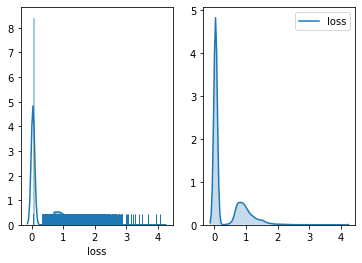

In [82]:
fig, axes = plt.subplots(1,2)  
sns.distplot(data_with_losses['loss'], ax = axes[0], kde = True, rug = True)        # kde 密度曲线  rug 边际毛毯  
sns.kdeplot(data_with_losses['loss'], ax = axes[1], shade=True)                     # shade  阴影                         
plt.show()  

In [79]:
thresh = 6  # threshold for anomaly, in sigmas.

In [80]:
data_with_losses['anomaly'] = data_with_losses['loss'] > (mean + sigma * thresh)
print(data_with_losses.head())
colors = ['red' if anomaly else 'blue' for anomaly in data_with_losses['anomaly']]

   uid  type  ifpic        r1        r2        r3        g1        g2  \
0    1     2      1  0.509085  0.916879 -0.866819  0.556730  0.725873   
1   12     2      1 -0.006644  0.899975 -0.567655  0.531048  0.513287   
2   18     2      0 -1.036753 -0.850720  0.555130 -1.022523 -0.985355   
3   22     2      0 -1.036753 -0.850720  0.555130 -1.022523 -0.985355   
4   35     2      0 -1.036753 -0.850720  0.555130 -1.022523 -0.985355   

         g3        b1        b2        b3       asm       con       eng  \
0 -0.919456  0.588853  0.598425 -0.799702 -0.117813  0.055439  1.462575   
1 -0.737549  0.902894  0.449059 -0.838995 -0.687405  0.540872  2.296487   
2  0.524007 -0.998609 -0.975355  0.505114 -0.902389 -0.682143 -0.983619   
3  0.524007 -0.998609 -0.975355  0.505114 -0.902389 -0.682143 -0.983619   
4  0.524007 -0.998609 -0.975355  0.505114 -0.902389 -0.682143 -0.983619   

        idm      loss  anomaly  
0  0.926437  0.655334    False  
1  0.493395  0.730622    False  
2 -1.098656

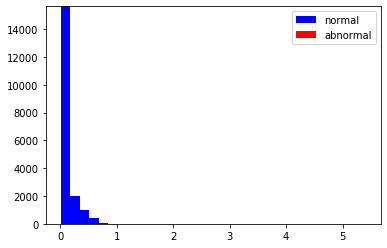

In [32]:
anomalies_loss = data_with_losses.loc[data_with_losses['anomaly'], 'loss']
normals_loss   = data_with_losses.loc[~data_with_losses['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'abnormal'])
plt.legend()

In [39]:
data_with_losses_unscaled = data_with_losses.copy()
data_with_losses_unscaled[cont_vars] = scaler.inverse_transform(data_with_losses[cont_vars])
data_with_losses_unscaled = pd.DataFrame(data_with_losses_unscaled, columns=data_with_losses.columns)
print(data_with_losses_unscaled.head())

       uid  type  ifpic          r1         r2         r3          g1  \
0  1088916     2      1   97.614978  67.456272  63.780334   97.087358   
1       37     2      0    0.057993   0.024396  -0.029042    0.048980   
2       42     2      1  212.405175  80.847712 -96.379919  211.349598   
3  1088924     2      0    0.057993   0.024396  -0.029042    0.048980   
4  1088942     2      1  102.540626  61.393805   9.708157  109.923367   

          g2         g3          b1         b2         b3       asm       con  \
0  68.117285  64.699577   90.991269  71.837066  67.974166  0.027085  8.851774   
1   0.021508   0.092140    0.010261   0.008832   0.060727  0.000009 -0.011093   
2  75.771202 -85.542578  224.618555  55.529670 -70.554195  0.442060  6.478422   
3   0.021508   0.092140    0.010261   0.008832   0.060727  0.000009 -0.011093   
4  65.996971 -32.987108   93.182573  60.048402 -14.858932  0.025685  3.052300   

        eng       idm      loss  anomaly  
0  4.346545  0.540460  0.114905

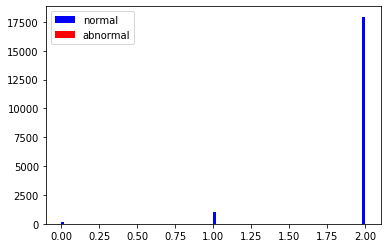

In [42]:
anomalies_value = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ['loss','type']]
normals_value = data_with_losses_unscaled.loc[~data_with_losses_unscaled['anomaly'], ['loss','type']]

plt.hist([normals_value['type'], anomalies_value['type']], bins=100, stacked=True, color=['blue', 'red'], label=['normal', 'abnormal'])
plt.legend()

In [ ]:
anomalies_ts = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ('t', 'value')]
holidays_ts = data_with_losses_unscaled.loc[data_with_losses_unscaled['holiday'] == 1, ('t', 'value')]
print(anomalies_ts.head())
fig, ax = plt.subplots()
ax.plot(data_with_losses_unscaled['t'], data_with_losses_unscaled['value'], color='blue')
ax.scatter(anomalies_ts['t'], anomalies_ts['value'], color='red', label='anomaly')
plt.legend()
plt.show()